In [1]:
import pandas as pd
import numpy as np
import sklearn
from numpy import ravel
from numpy import unique
from numpy import transpose
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Data

In [2]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ5JE66pQB1KJItYr2QUVldTeOGDUfgWwV8u5VdmGkkm6fjZgwCU0-owOzBFakl_aYfsF2aL6xNxRwc/pub?gid=161992597&single=true&output=csv"
colmns = ["name", "date", "freq_sum", "market", "t"]

data = pd.read_csv(url, usecols = colmns)
unique_items = data.loc[:, "name"].unique()


In [3]:
data.dtypes

name        object
date         int64
t            int64
freq_sum     int64
market       int64
dtype: object

In [4]:
data['freq_sum_log10'] = np.log10(data['freq_sum'])
data['market_log10'] = np.log10(data['market'])

In [5]:
data[data.market_log10 < 8].name.unique()

array(['Серебро', 'Сырая нефть'], dtype=object)

In [6]:
data_ = data[(data.loc[:, "name"] != 'Серебро') & (data.loc[:, "name"] != 'Сырая нефть')]

In [7]:
unique_items = data_.loc[:, "name"].unique()

# Model

# Updated model

In [8]:
model__ = RandomForestRegressor(n_estimators=350, random_state=12)
train = data_.copy(deep=True)
# X_train, y_train = train.loc[:, ["freq_sum_log10", "t"]], train.loc[:, ["sum_volume_log10"]]
# model__.fit(X_train, y_train)

score_list = []

table_names = []
actuals = []
model_predicts = []
# epsilon = 0.1
base = 10.18

for item in unique_items:
    test = data_[data_.loc[:, "name"] == item]
    X_test, y_test = test.loc[:, ["freq_sum_log10", "t"]], pd.DataFrame(test.loc[:, ["market_log10"]])
    preds = []
    for item_ in unique_items:      
        train_ = data_[data_.loc[:, "name"] != item_]
        X_train, y_train = train_.loc[:, ["freq_sum_log10", "t"]], pd.DataFrame(train_.loc[:, ["market_log10"]])
        model__.fit(X_train, ravel(y_train)) #fit on train set, that contains all the obs except for item_
        preds.append(model__.predict(X_test))
        
    matrix__ = np.array(preds).transpose()
    df_pred = pd.DataFrame(matrix__)
    df_pred["prediction"] = df_pred.mean(axis = 1)
    y_test_unlogged = test.market
    y_pred_unlogged = []
    for instance_2 in df_pred["prediction"]:
        y_pred_unlogged.append(base**instance_2)

    actuals.extend(y_test_unlogged)
    model_predicts.extend(y_pred_unlogged)
#     result_out2 = r2_score(y_test_unlogged, y_pred_unlogged)
#     print(result_out2)
#     score_list.append(result_out2)

actuals_20 = actuals[19::20]
model_predicts_20 = model_predicts[19::20]
r2_score_ = r2_score(actuals_20, model_predicts_20)
# print(base)
print(r2_score_)

0.7800170652817063


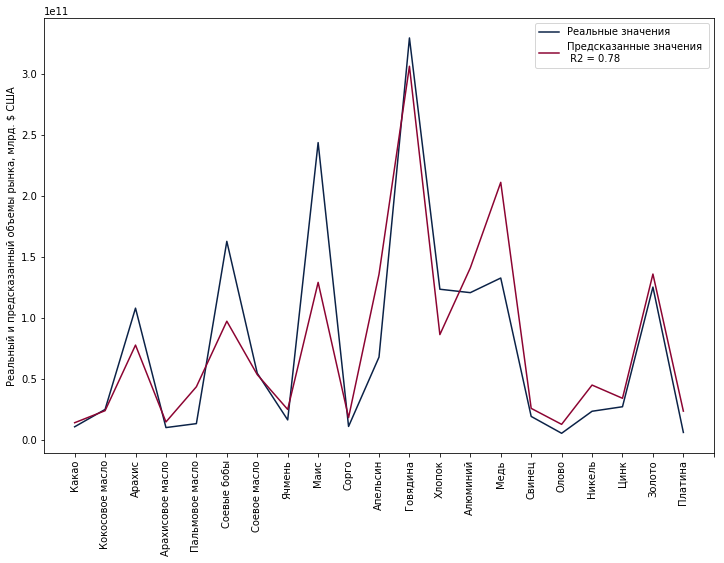

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
a = list(range(22))

plt.figure(figsize=(12, 8))
plot1, = plt.plot(actuals_20, color = "#0b2247")
plot2, = plt.plot(model_predicts_20, color = "#8c0432") #520821
plt.xticks(a, unique_items, rotation='vertical')
# values = [0, 2*10**10, 4*10**10, 6*10**10, 8*10**10, 10*10**10, 12*10**10]
# labels = [0, 20, 40, 60, 80, 100, 120]
# plt.yticks(values, labels)
plt.ylabel("Реальный и предсказанный объемы рынка, млрд. $ США")
plt.legend([plot1, plot2], ["Реальные значения", f"Предсказанные значения \n R2 = {r2_score_:.3}"])
plt.show()
